In [18]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Librería matriz de confusión
from sklearn.metrics import confusion_matrix
# Librería para curva de ROC
from sklearn.metrics import roc_curve, auc
# Para separar train y test 
from sklearn.model_selection import train_test_split
# Librerias para regresión logística
from sklearn.linear_model import LogisticRegression

# Para instalar paquetes: 
# %pip install statsmodels --trusted-host pypi.org --trusted-host files.pythonhosted.org

In [2]:
url = 'Titanic.csv'
df = pd.read_csv(url, sep = ',')

In [43]:
# Antes de entrenar, completo valores vacíos de la variable edad: 
edad_mediana = df['Age'].median()
df['Age_Completa'] = df['Age'].fillna(edad_mediana,
                                      inplace = False)
df['Age_Completa_log'] = np.log(df['Age_Completa'] )

# Genero binaria sexo 
df['Es_Fem'] = np.where(df['Sex'] == 'female',1,0)

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Completa,Es_Fem
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,0


# Previo a modelar: 
Primero debemos particionar nuestro dataset en dos, una porción de entrenamiento y otra de testeo. Para hacer esta partición, haremos una distribución de 70% del total de la muestra para entrenamiento y 30% del total de la muestra para testeo. 
<br> 

**¿Qué esperamos que suceda?**
<br>
Que los resultados observados en la muestra de testeo sean similares a los de entrenamiento, para poder asumir que el modelo puede **GENERALIZAR** y mantener su estabilidad y confianza en predicciones nuevas. 

## TRAIN Y TEST 

In [45]:
df_train,df_test = train_test_split(df,
                                        test_size = 0.30, #Porcentaje de muestra test 
                                        random_state = 44) #Semilla

# Check tasas similares 
print('Tasa Supervivencia TRAIN:')
print(round(df_train['Survived'].mean(),2))
print('Tasa Supervivencia TEST:')
print(round(df_test['Survived'].mean(),2))

Tasa Supervivencia TRAIN:
0.38
Tasa Supervivencia TEST:
0.39


# Modelo Ejemplo

In [46]:
# Variables predictoras
features = ['Es_Fem', 'Age_Completa_log']

# Features 
X = df_train[features]

# Variable objetivo
y = df_train['Survived']

# Modelo
model = LogisticRegression()
model.fit(X, y)

# Extraemos coeficientes
coef_values = model.coef_[0]
feature_names = X.columns.tolist()

# Creamos el DataFrame
coef_df = pd.DataFrame({
    'Variable': feature_names + ['Intercepto'],
    'Coeficiente': list(coef_values) + [model.intercept_[0]]
})

# Redondeamos para presentación
coef_df['Coeficiente'] = coef_df['Coeficiente'].round(4)

# Mostrar tabla ordenada
print("\n📊 Coeficientes del modelo:")
print(coef_df)



📊 Coeficientes del modelo:
           Variable  Coeficiente
0            Es_Fem       2.5660
1  Age_Completa_log      -0.3614
2        Intercepto      -0.2852


In [47]:
# Predicciones 
df_train['Predict_Prob_RegLog_1'] = model.predict(df_train[features])
df_test['Predict_Prob_RegLog_1'] = model.predict(df_test[features])

## Métricas de Validación

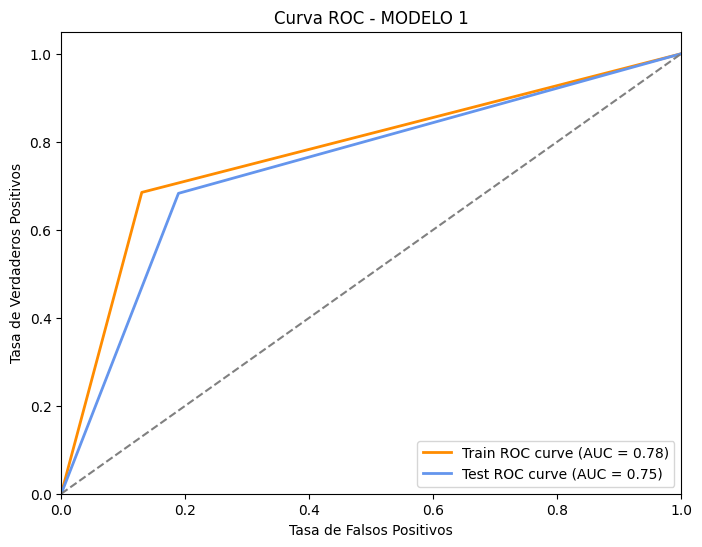

In [48]:
# 3) Curvas de ROC
# Calcula las curvas ROC y el área bajo la curva (AUC) para entrenamiento y prueba

y_train = df_train['Survived']
y_train_proba = df_train['Predict_Prob_RegLog_1']
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

y_test = df_test['Survived']
y_test_proba = df_test['Predict_Prob_RegLog_1']
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafica las curvas ROC en el mismo gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - MODELO 1')
plt.legend(loc='lower right')
roc_1 = plt.gcf()
plt.show()

# **Shap Values**

In [25]:
import shap

In [49]:
print(coef_df)

           Variable  Coeficiente
0            Es_Fem       2.5660
1  Age_Completa_log      -0.3614
2        Intercepto      -0.2852


## Partial Dependence Plot (PDP)

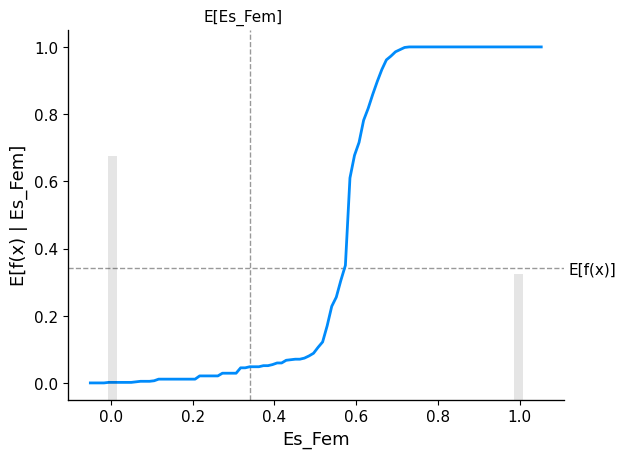

In [50]:
# Subset de predictores
X = df_train[['Es_Fem', 'Age_Completa_log']]

# Plot de dependencia parcial
shap.partial_dependence_plot(
    "Es_Fem",
    model.predict,  # o model.predict_proba si querés probabilidades
    X,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

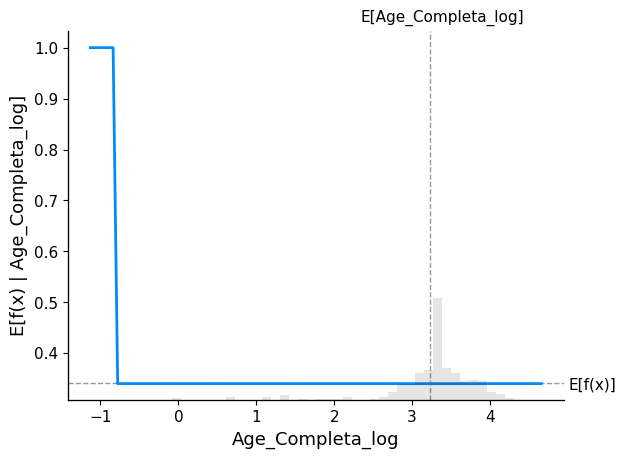

In [52]:
# Plot de dependencia parcial
shap.partial_dependence_plot(
    "Age_Completa_log",
    model.predict,  # o model.predict_proba si querés probabilidades
    X,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

## Waterfall Plot SHAP

In [55]:
# Primero, distribución general 
print('Tasa Promedio:',df_train['Survived'].mean().round(2))
print('Prediccion Promedio:',df_train['Predict_Prob_RegLog_1'].mean().round(2))

Tasa Promedio: 0.38
Prediccion Promedio: 0.34


In [53]:
# Luego, distribución por variable Es_Fem 
df_train.groupby('Es_Fem').agg(
    Cantidad = ('Survived', 'count'),
    Tasa = ('Survived', 'mean')
).reset_index()

,Es_Fem,Cantidad,Tasa
0,0,411,0.184915
1,1,212,0.764151


In [57]:
# Luego, distribución por variable Edad 
df_train['Edad_cuartiles'] = pd.qcut(df_train['Age_Completa_log'], q=4, labels=['Q1','Q2','Q3','Q4'])
df_train.groupby('Edad_cuartiles').agg(
    Cantidad = ('Survived', 'count'),
    Tasa = ('Survived', 'mean'),
    Edad_Min = ('Age_Completa', 'min')
).reset_index()

C:\Users\X15119\AppData\Local\Temp\ipykernel_16604\1231832270.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby('Edad_cuartiles').agg(


,Edad_cuartiles,Cantidad,Tasa,Edad_Min
0,Q1,159,0.408805,0.42
1,Q2,220,0.336364,23.00
2,Q3,89,0.471910,28.50
3,Q4,155,0.367742,36.00


Registro Nro: 10

Valores:
Es_Fem                         1
Age_Completa_log         3.89182
Predict_Prob_RegLog_1          1
Survived                       1
Name: 52, dtype: object


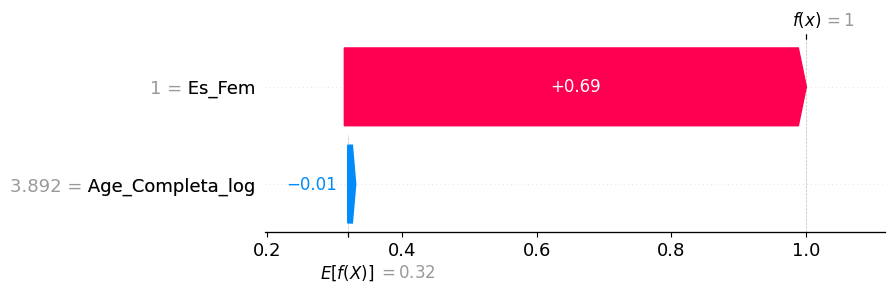

In [74]:
# compute the SHAP values for the linear model
sample_ind = 10
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)

# Valores del registro
cols = features + ['Predict_Prob_RegLog_1', 'Survived']

print('Registro Nro:', sample_ind)
print('')
print('Valores:')
print(df_train.iloc[sample_ind,][cols])

# Shap values 
shap.plots.waterfall(shap_values[sample_ind], max_display=14)


## SHAP Beeswarm Plot

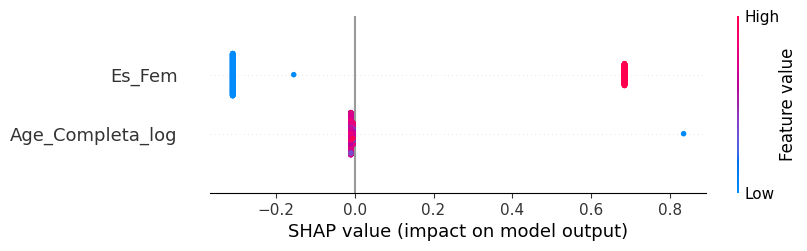

In [75]:
# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model.predict, X)
shap_values_ebm = explainer_ebm(X)
shap.plots.beeswarm(shap_values_ebm)

### Interpretación de distribuciones de SHAP Values: 

* *Es_Fem:* Los valores celestes se concentran en en SHAP values negativos, y los valores rojos en SHAP values positivos. Esto indica que ser mujer, incrementa la probabilidad de sobrevivir. 

* *Age_Completa_log:* La mayor parte de SHAP values se concentran en cero, por lo que la variable no tiene gran impacto en las predicciones. Además, como los colores rojos y celestes se encuentran muy superpuestos, significa que no hay una relación clara y consistente entre el valor de la variable y la predicción.

## SHAP Dependence Plot

**Aclaración:** automáticamente, la función de SHAP al hacer un shap.plots.scatter() con color=shap_values, elige una variable del dataset que:

* Tiene alta correlación con la variable que estás graficando,

* Tiene interacción relevante con ella,

* Afecta el modelo en conjunto con esa variable.

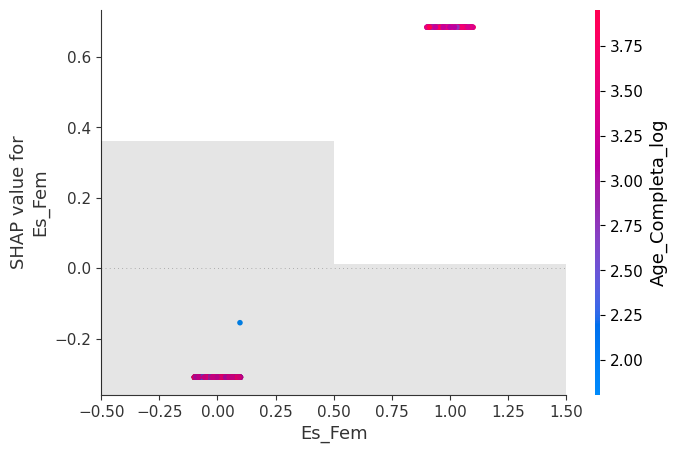

In [76]:
shap.plots.scatter(shap_values_ebm[:, "Es_Fem"], color=shap_values)

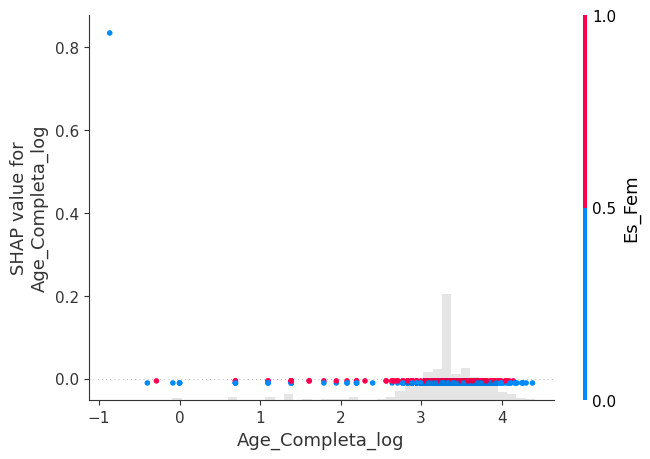

In [80]:
shap.plots.scatter(shap_values_ebm[:, "Age_Completa_log"], color=shap_values)